In [2]:
from libraries.DES import *
from libraries.theoretical_results import *
import matplotlib.pyplot as plt
import numpy as np

In [36]:
def run_simulations(rho_steps, num_samples, num_servers, policy,queuetype="MM",rho_range=(0.1,1),mu=1):
    """Runs the simulation for a given number of steps and samples

    Args:
        steps (int): Number of steps
        num_samples (int): Number of samples
        num_servers (int): Number of servers
        policy (str): Scheduling policy
        queuetype (str, optional): Type of queue. Defaults to "MM". Options are "MM", "MD", "MC".

    Returns:
        list: Average wait times
        list: Standard deviations
        list: System loads
        list: Service rates
        list: Arrival rates
    """
    # Initialize lists
    rho_list = []
    mu_list = []
    lamda_list = []
    averages_of_average_wait_times = []
    std_devs = []

    for rho in np.linspace(rho_range[0],rho_range[1], rho_steps):
        # Calculate lambda
        mu = mu
        lamda = rho * mu
        # Run simulation for num_samples
        average_wait_times = []
        until = average_waiting_time(lamda,mu)
        for _ in range(num_samples):
            wait_times = []
            env = simpy.Environment()
            env.process(run_server(env, num_servers, lamda, mu, wait_times, policy,queuetype=queuetype))
            env.run(until=min(until*200,20000))
            average_wait = get_average_wait_time(wait_times[-80:])
            average_wait_times.append(average_wait)
        # Append results to lists
        rho_list.append(rho)
        mu_list.append(mu)
        lamda_list.append(lamda)
        
        averages_of_average_wait_times.append(statistics.mean(average_wait_times))
        std_devs.append(np.std(average_wait_times))
    
    return averages_of_average_wait_times, std_devs, rho_list, mu_list, lamda_list

# 2) Write a DES program to verify the theoretical results with simulations for n=1,n=2,n=4.

Below we plot the results for n=1, n=2 and n=4. We compare them to the theoretical result for values of $\rho$ ranging from 0.85 to 0.999.


In [37]:
rho_range = (.85,.999)
num_rho_steps = 10
num_sims=60
averages_of_average_wait_times, std, rho_list, mu_list, lamda_list = run_simulations(num_rho_steps,num_sims,1,"FIFO",rho_range=rho_range)

   

KeyboardInterrupt: 

In [ ]:
def plot_compare_theory_vs_sim():
    """Plots the theoretical results against the simulation results
    """
    exact_rhos = np.linspace(rho_range[0],.999,500)
    exact_wait_times = average_waiting_time(exact_rhos,1)
    plt.title('Average waiting time for M/M/1 queue')
    plt.errorbar(rho_list, averages_of_average_wait_times, yerr=std/np.sqrt(num_sims), fmt="o",label='Simulation and SEM')
    plt.plot(exact_rhos,exact_wait_times ,label='theoretical')
    plt.xlabel(r'$\rho$ (system load)')
    plt.ylabel('Average waiting time (arbitrary units)')
    plt.ylim(-1,max(averages_of_average_wait_times)+max(std/np.sqrt(num_sims))+5)
    plt.legend()
    plt.show()

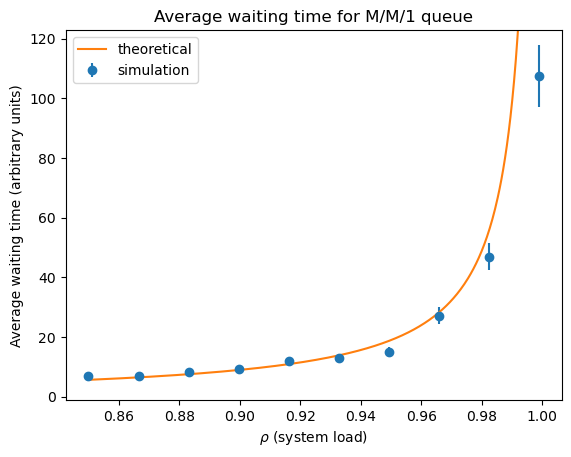

In [35]:




# num_server = [1,2,4]
# for cashiers in num_server:
#     # Setup
#     num_cashiers = cashiers
#     lamda=1
#     mu =1


#     # Run the simulation
#     env = simpy.Environment()
#     env.process(run_theater(env, num_cashiers, lamda, mu))
#     env.run(until=90)

#     # View the results
#     mins, secs = get_average_wait_time(wait_times)
#     print(
#         "Running simulation...",
#         f"\nThe average wait time for {cashiers} cashier(s) is {mins} minutes and {secs} seconds.",
#     )
